In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample




















In [4]:
# 1. Load your CSV
file_path = r"A:\Data Science Projects\archive\supply_chain_data.csv"
df = pd.read_csv(file_path, encoding='ISO-8859-1')

In [ ]:
#Cleaning Column names
df.columns = df.columns.str.strip()  

In [7]:
print(df.columns.tolist())

['Product type', 'SKU', 'Price', 'Availability', 'Number of products sold', 'Revenue generated', 'Customer demographics', 'Stock levels', 'Lead times', 'Order quantities', 'Shipping times', 'Shipping carriers', 'Shipping costs', 'Supplier name', 'Location', 'Lead time', 'Production volumes', 'Manufacturing lead time', 'Manufacturing costs', 'Inspection results', 'Defect rates', 'Transportation modes', 'Routes', 'Costs']


In [8]:
# 3. Keep relevant columns
required_cols = ['SKU', 'Product type', 'Availability', 'Price', 'Defect rates', 'Lead time']
df = df[required_cols].dropna()


In [10]:
#Create synthetic supplier messages
def create_supplier_message(row):
    base = f"SKU {row['SKU']} ({row['Product type']}) is currently available with {row['Availability']} units at ${row['Price']}."
    
    if row['Availability'] < 20:
        return base + " We're requesting urgent restock due to low inventory."
    elif row['Price'] > 250:
        return base + " We'd like to discuss the recent price increase."
    elif row['Defect rates'] > 0.1:
        return base + " We are concerned about quality due to high defect rates."
    else:
        return base + " Just checking general availability and performance."


In [11]:
## Applying function across all the rows
df['supplier_message'] = df.apply(create_supplier_message, axis=1)

Index(['SKU', 'Product type', 'Availability', 'Price', 'Defect rates',
       'Lead time', 'supplier_message'],
      dtype='object')

In [14]:
# 5. Logic for Labeling messages
def label_message(text):
    text = text.lower()
    if "urgent restock" in text:
        return "Restock Request"
    elif "price increase" in text:
        return "Price Concern"
    elif "defect" in text or "quality" in text:
        return "Quality Issue"
    else:
        return "General Inquiry"

In [15]:
df['label']  = df['supplier_message'].apply(label_message)

In [25]:
print("\n📊 Label distribution BEFORE balancing:")
print(df['label'].value_counts())

# 7. Balance classes via upsampling
target_size = df['label'].value_counts().max()  # e.g., 73
balanced_dfs = []

for label, group in df.groupby('label'):
    if len(group) < target_size:
        upsampled = resample(group, replace=True, n_samples=target_size, random_state=42)
        balanced_dfs.append(upsampled)
    else:
        balanced_dfs.append(group)

df_balanced = pd.concat(balanced_dfs).reset_index(drop=True)


📊 Label distribution BEFORE balancing:
label
Quality Issue      73
Restock Request    24
General Inquiry     3
Name: count, dtype: int64


In [26]:
# 8. Check label distribution after balancing
print("\n✅ Label distribution AFTER balancing:")
print(df_balanced['label'].value_counts())


✅ Label distribution AFTER balancing:
label
General Inquiry    73
Quality Issue      73
Restock Request    73
Name: count, dtype: int64


In [28]:
# 9. Train/test split
X = df_balanced['supplier_message']
y = df_balanced['label']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [30]:
## Building pipeline for TFIDF and for LogisticRegression

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegression(max_iter=1000))
])

In [32]:
## Training dataset
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('clf', LogisticRegression(max_iter=1000))])

In [33]:
y_pred = pipeline.predict(X_test)


In [35]:
## Evaluating Model Performance

acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Accuracy: {acc:.4f}")gkgjhhjh
print("\n📄 Classification Report:\n", classification_report(y_test, y_pred))
print("\n📌 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



✅ Accuracy: 1.0000

📄 Classification Report:
                  precision    recall  f1-score   support

General Inquiry       1.00      1.00      1.00        14
  Quality Issue       1.00      1.00      1.00        15
Restock Request       1.00      1.00      1.00        15

       accuracy                           1.00        44
      macro avg       1.00      1.00      1.00        44
   weighted avg       1.00      1.00      1.00        44


📌 Confusion Matrix:
 [[14  0  0]
 [ 0 15  0]
 [ 0  0 15]]


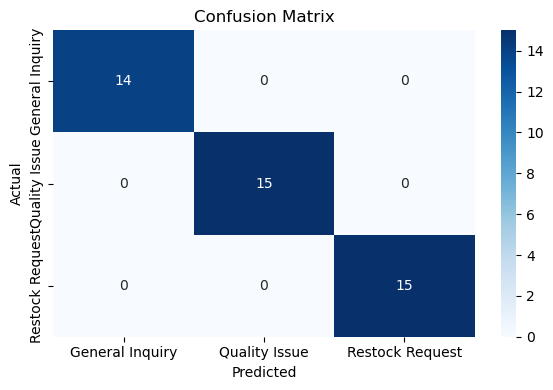

In [36]:
# 12. Visualize Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=pipeline.classes_, yticklabels=pipeline.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
